In [73]:
from utilities.constants import *
from utilities.temporal_analysis import *
import matplotlib.pyplot as plt
from utilities.model_matching_computation import *
from utilities.features_eng import *
import pandas as pd
from music21 import *
from utilities.corpus_search import *
from mutagen.mp3 import MP3
import math
from scipy import stats
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.utils as rnn_utils
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict

In [71]:
label = 'tab'
random_state = 42
le = LabelEncoder()
df_labeled_notes_t1 = pd.read_json('note_corpus3.json', orient ='split', compression = 'infer')
#df_labeled_notes_t1 = get_timestamps_from_all_corpus()
df_labeled_notes_t1['tie'] = df_labeled_notes_t1['tie'].fillna(-1)

df_labeled_notes_t1 = df_labeled_notes_t1.dropna()
df_labeled_notes_t1['NoteAndRest'] = df_labeled_notes_t1['NoteAndRest'].apply(lambda x: re.sub(r'\d+', '', x))
df_labeled_notes_t1['quarterLength'] = [1/3 if i == '1/3' else i for i in df_labeled_notes_t1['quarterLength']]
df_labeled_notes_t1['offset'] = [8/3 if i == '8/3' else i for i in df_labeled_notes_t1['offset']]
df_labeled_notes_t1['offset'] = [7/3 if i == '7/3' else i for i in df_labeled_notes_t1['offset']]
df_labeled_notes_t1['LetterNotes'] = df_labeled_notes_t1['NoteAndRest'] 
df_labeled_notes_t1['NoteAndRest'] = df_labeled_notes_t1['NoteAndRest'].apply(lambda x: note_to_midi(x))
df_labeled_notes_t1 = label_length(df_labeled_notes_t1)
mask = df_labeled_notes_t1[df_labeled_notes_t1['NoteAndRest'] != -1]
df_labeled_notes_t1.loc[mask.index, 'NoteAndRest'] = (
    df_labeled_notes_t1.loc[mask.index, 'NoteAndRest'] - df_labeled_notes_t1.loc[mask.index, 'NoteAndRest'].mean()
) / df_labeled_notes_t1.loc[mask.index, 'NoteAndRest'].std()

keys_to_encode = df_labeled_notes_t1['key'].apply(lambda x: str(x)).tolist()
df_labeled_notes_t1['key'] =  le.fit_transform(keys_to_encode)



df_windowed = return_windowed_df(df_labeled_notes_t1, ['NoteAndRest', 'LetterNotes', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', 'tie','nawba', 'mizan', 'tab'], label, apply_stride=True, length_sequence=512)
# Create new dataset with translated notes to pitch
df_midi = df_windowed.copy()

df = df_midi[df_midi[label].isin(LABEL_LIST_TRAIN[label])]
pitch_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(compute_avg_folded_hist_labeled_notes(x['LetterNotes'].tolist(), x['quarterLength'].tolist())))
ql_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(get_folded_rhythm_histogram(x['quarterLength'].tolist())))
#df = df[df['length_section'] > 30]
df = label_length(df)

# NORMALIZATION
to_norm = ['bpm', 'length_section', 'beatStrength', 'offset', 'quarterLength']
for column_to_normalize in to_norm:
    df[column_to_normalize] = (df[column_to_normalize] - df[column_to_normalize].mean()) / df[column_to_normalize].std()


df['tie'] = df['tie'].apply(lambda x: 1 if type(x) ==str else 0)
df['is_rest'] = [1 if x == -1 else 0 for x in df['NoteAndRest'].tolist()]
keys_to_encode = df['key'].apply(lambda x: str(x)).tolist()
df['key'] =  le.fit_transform(keys_to_encode)
df

/tmp/ipykernel_54111/603874752.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.2865325   0.65760694  0.65760694 ... -1.54363254 -1.54363254
 -0.91470698]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_labeled_notes_t1.loc[mask.index, 'NoteAndRest'] = (
/home/ale/nawba_recognition_task/utilities/features_eng.py:135: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all = pd.concat([temp, all])
/tmp/ipykernel_54111/603874752.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from

,NoteAndRest,LetterNotes,quarterLength,timestamp_(scs),bpm,key,offset,beatStrength,tie,nawba,mizan,tab,section_id,length_section,is_rest
0,0.028681,F,-0.314970,1462.53,-0.888074,0,-1.177964,2.223552,0,2.0,3.0,2.0,fb387964-4764-4900-91b5-f2ea7e10b78630,1.249033,0
1,-0.285781,E,-0.314970,1463.03,-0.888074,0,-0.926433,-0.676751,0,2.0,3.0,2.0,fb387964-4764-4900-91b5-f2ea7e10b78630,1.249033,0
2,-0.914707,D,-0.314970,1463.53,-0.888074,0,-0.674902,-0.262422,0,2.0,3.0,2.0,fb387964-4764-4900-91b5-f2ea7e10b78630,1.249033,0
3,-1.543633,C,-0.314970,1464.03,-0.888074,0,-0.423370,-0.676751,0,2.0,3.0,2.0,fb387964-4764-4900-91b5-f2ea7e10b78630,1.249033,0
4,1.915458,B,-0.314970,1464.53,-0.888074,0,-0.171839,0.566236,0,2.0,3.0,2.0,fb387964-4764-4900-91b5-f2ea7e10b78630,1.249033,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819195,0.028681,F,-0.314970,615.23,-0.734871,0,1.588878,-0.883916,0,1.0,10.0,1.0,023b4a37-1ab4-4593-b03a-850ee0db835020,0.637563,0
819196,0.657607,G,1.136364,615.69,-0.734871,0,1.840409,-0.262422,0,1.0,10.0,1.0,023b4a37-1ab4-4593-b03a-850ee0db835020,0.637563,0
819197,0.028681,F,1.136364,616.62,-0.734871,0,2.343472,-0.676751,0,1.0,10.0,1.0,023b4a37-1ab4-4593-b03a-850ee0db835020,0.637563,0
819198,-0.285781,E,-0.314970,617.54,-0.734871,0,-1.177964,2.223552,0,1.0,10.0,1.0,023b4a37-1ab4-4593-b03a-850ee0db835020,0.637563,0


In [72]:
to_stratify = []
prefix_to_ids = defaultdict(list)
prev_pref = ""
for id_ in df['section_id'].unique():
    prefix = id_[:PREFIX_LENGTH]
    prefix_to_ids[prefix].append(id_)
    if prev_pref != prefix:
        to_stratify.append(df.loc[df['section_id'].str.contains(id_)][label].tolist()[0])
        prev_pref = prefix
prefixes = list(prefix_to_ids.keys())



"""
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_, y, 
    test_size=0.2,           
    stratify=y,             
    random_state=45         
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, 
    test_size=0.25,          
    stratify=y_train_temp,             
    random_state=45        
)

grouped = shuffled_df.groupby("section_id", group_keys=True)[['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', label]]
group_arrays = {section_id: group.values for section_id, group in grouped}
avg_sequence_length = 0
sequences_features = []
X_train = []
y_train = []
X_test = []
y_test = []
for key, values in group_arrays.items():
    if key in train_ids:
        X_train.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
        y_train.append((values[0][-1]))
    else:
        X_test.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
        y_test.append((values[0][-1]))

    sequences_features.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))

    avg_sequence_length += len(values) 

sequences_features = [list(x.values()) for x in sequences_features]
X_train = [list(x.values()) for x in X_train]
X_test = [list(x.values()) for x in X_test]
"""

'\nX_train_temp, X_test, y_train_temp, y_test = train_test_split(\n    X_, y, \n    test_size=0.2,           \n    stratify=y,             \n    random_state=45         \n)\nX_train, X_val, y_train, y_val = train_test_split(\n    X_train_temp, y_train_temp, \n    test_size=0.25,          \n    stratify=y_train_temp,             \n    random_state=45        \n)\n\ngrouped = shuffled_df.groupby("section_id", group_keys=True)[[\'NoteAndRest\', \'quarterLength\', \'timestamp_(scs)\', \'length_section\', \'bpm\', \'key\', \'offset\', \'beatStrength\', label]]\ngroup_arrays = {section_id: group.values for section_id, group in grouped}\navg_sequence_length = 0\nsequences_features = []\nX_train = []\ny_train = []\nX_test = []\ny_test = []\nfor key, values in group_arrays.items():\n    if key in train_ids:\n        X_train.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))\n        y_train.append((values[0][-1]))\n    else:\n        X_test.append(extract_feature(

In [74]:

# Extract global features for each sequence
grouped = df.groupby("section_id", group_keys=True)[['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength']]
group_arrays = {section_id: group.values for section_id, group in grouped}    
avg_sequence_length = 0
sequences_features = []
for key, values in group_arrays.items():
    sequences_features.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
    avg_sequence_length += len(values) 

sequences_features = [list(x.values()) for x in sequences_features]

In [75]:
# Normalize global features
scaler = StandardScaler()
sequences_features = np.array(sequences_features)
index = list(range((sequences_features.shape[1]) -1))
features_toNormalize = sequences_features[:, index]
normalized_features = scaler.fit_transform(features_toNormalize)

# Replace the original features with the normalized ones
sequences_features[:, index] = normalized_features
sequences_features

array([[ 0.63756378, -1.35850444,  0.98925689, ..., -3.81178086,
        -1.97518728,  0.        ],
       [ 0.96829012, -0.12346463,  1.3804305 , ...,  0.51987232,
         0.46676233,  0.        ],
       [ 1.27721717, -0.48297541,  1.38274788, ...,  0.80316776,
         0.59570859,  0.        ],
       ...,
       [-1.19248645, -0.27793613,  1.30627436, ..., -1.12519866,
        -0.21953419,  0.        ],
       [-0.44741793, -0.13253409,  1.34242548, ..., -0.48576644,
         0.31053232,  0.        ],
       [ 1.2490338 , -0.4773599 , -0.63383551, ..., -0.17425829,
         1.69995085,  0.        ]])

In [76]:
def transpose_df(df, columns, label):
    grouped = df.groupby("section_id", group_keys=True)[columns]
    all = []
    for section_id, group in grouped:
        all.append([[[x[0], x[1], x[3], x[4], x[5], 1 if x[0] == -1 else 0]for x in group.values[:]] , section_id, group.values[0][2]] )
  
    return pd.DataFrame(all, columns=['NoteAndRest', 'section_id', label])
df_windowed = transpose_df(df,  ['NoteAndRest', 'quarterLength', label, 'offset', 'beatStrength', 'is_rest'], label)
df_windowed['global_features'] = list(sequences_features)
# Reset labels into range (0, n)
df_windowed[label] = df_windowed[label].apply(lambda x: replace_label(x, label))

"""
train_df = df[df['section_id'].isin(train_ids)]
X_train, y_train = train_df[['NoteAndRest', 'global_features']], train_df[label]
test_df = df[df['section_id'].isin(test_ids)]
X_test, y_test = test_df[['NoteAndRest', 'global_features']], test_df[label]
val_df = df[df['section_id'].isin(val_ids)]
X_val, y_val = val_df[['NoteAndRest', 'global_features']], val_df[label]
"""


"\ntrain_df = df[df['section_id'].isin(train_ids)]\nX_train, y_train = train_df[['NoteAndRest', 'global_features']], train_df[label]\ntest_df = df[df['section_id'].isin(test_ids)]\nX_test, y_test = test_df[['NoteAndRest', 'global_features']], test_df[label]\nval_df = df[df['section_id'].isin(val_ids)]\nX_val, y_val = val_df[['NoteAndRest', 'global_features']], val_df[label]\n"

In [78]:
class NoteSequenceDataset(Dataset):
    def __init__(self, sequences, global_features, labels):
        self.sequences = sequences
        self.global_features = global_features
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Returns the lists into a converted torch for RNN usage
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)  
        global_feat = torch.tensor(self.global_features[idx], dtype=torch.float32)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)  

        return sequence, global_feat, label

# Split train-test-val into 60-20-20

"""
y = df_windowed[label]
X_ = df_windowed[['NoteAndRest', 'global_features']]
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_, y, 
    test_size=0.2,           
    stratify=y,             
    random_state=45         
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, 
    test_size=0.25,          
    stratify=y_train_temp,             
    random_state=45        
)
"""

"\ny = df_windowed[label]\nX_ = df_windowed[['NoteAndRest', 'global_features']]\nX_train_temp, X_test, y_train_temp, y_test = train_test_split(\n    X_, y, \n    test_size=0.2,           \n    stratify=y,             \n    random_state=45         \n)\nX_train, X_val, y_train, y_val = train_test_split(\n    X_train_temp, y_train_temp, \n    test_size=0.25,          \n    stratify=y_train_temp,             \n    random_state=45        \n)\n"

In [53]:
"""from torch.optim.lr_scheduler import StepLR
device = torch.device('cpu')
# RNN Parameters
input_size = 6
sequence_length = 512
num_layers = 8
hidden_size = 128
num_classes = len(LABEL_LIST_TRAIN[label])
learning_rate = 1e-3
batch_size = 16
num_epochs = 200
patience = 10
# EMBEDDING Parameters
num_keys = len(df['key'].unique())
key_embed_dim = 4
# GLOBAL FEATURES Parameters
global_feat_dim = 38
global_out_dim = 19

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,
                 num_keys, key_embed_dim, global_feat_dim, global_out_dim):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=False)
        
        # Convert key embedding into a 4D vector
        #self.key_embedding = nn.Embedding(num_keys, key_embed_dim)
        
        # MLP for global features of sequence
        """
        self.global_fc = nn.Sequential(
            nn.Linear(global_feat_dim, global_out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        """
        # Convert into right dimension for FC layer
        self.classifier = nn.Sequential(
            #nn.Linear(hidden_size + key_embed_dim + global_out_dim, 64),
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, key, global_feats):
        lstm_out, (h_n, _) = self.lstm(x)
        
        # We have a bidirectinal movement, so we get the two last hidden states
        #forward = h_n[-2]
        backward = h_n[-1]

        # We get emeddings of sequences, keys and global features
        #lstm_feat = torch.cat((forward, backward), dim=1)
        #key_vec = self.key_embedding(key)
        #global_vec = self.global_fc(global_feats)
        #combined = torch.cat([backward, key_vec, global_vec], dim=1)

        # Passed into dimension reduction for output layer
        out = self.classifier(backward)
        return out

# We prepare the train, test and validation loaders
dataset_train = NoteSequenceDataset(X_train['NoteAndRest'].tolist(), X_train['global_features'].tolist(), y_train.tolist())
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = NoteSequenceDataset(X_test['NoteAndRest'].tolist(), X_test['global_features'].tolist(), y_test.tolist())
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
dataset_val = NoteSequenceDataset(X_val['NoteAndRest'].tolist(), X_val['global_features'].tolist(), y_val.tolist())
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

model = RNN(input_size, hidden_size, num_layers, num_classes,
                 num_keys, key_embed_dim, global_feat_dim, global_out_dim).to(device)


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.tolist()), y=y_train.tolist())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer= optimizer, step_size=20, gamma=0.1)
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    model.train()
    for batch_idx, (sequences, global_feats, labels) in enumerate(train_loader):
        # Reset gradients
        optimizer.zero_grad()   # Float keys are converted into long
        output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])  # Assuming global_feats[:, 0] is the key, global_feats[:, 1:] is the other features
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Just for visualization
        probs = torch.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)
        if batch_idx % 10 == 0:
            print("Targets:", labels.tolist())
            print("Preds:", preds.tolist())
            print("Probs:", probs.tolist())
            print("Train loss: ", loss) 
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        # Update
        optimizer.step()
    
    # VALIDATION Step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, global_feats, labels in val_loader:
            output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])
            loss = criterion(output, labels)
            val_loss += loss.item()
            
            
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    if avg_val_loss > best_loss:
        patience -= 1
    else:
        best_loss = avg_val_loss
        patience = 10

    if patience <= 0:
        break
    val_acc = correct / total
    print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.4f}, Best Val Loss = {best_loss:.4f}, Val Acc = {val_acc:.4f}, Patience = {patience:.4f},")
    scheduler.step()
print(f"Finished at epoch {epoch}"
"""

IndentationError: unexpected indent (1499985793.py, line 32)

In [79]:
# Accuracy function
def check_accuracy(loader, model):
    model.eval()
    total = 0
    correct = 0
    pred = []
    actual = []
    with torch.no_grad():
        for sequences, global_feats, labels in loader:
            #data, targets = batch
            output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])
            _, predicted = torch.max(output.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f"Predictions: {predicted.tolist()}")
            print(f"Actual: {labels.tolist()}")
            pred.extend(predicted.tolist())                                                                                                                                                       
            actual.extend(labels.tolist())                                                                                                                                                       

    accuracy = float(correct) / float(total) * 100
    print(f'Got {correct} / {total} correct with accuracy {accuracy:.2f}')
    model.train()
    return actual, pred, accuracy

#check_accuracy(train_loader, model)
#check_accuracy(test_loader, model)

In [68]:
from torch.optim.lr_scheduler import StepLR
device = torch.device('cpu')
# RNN Parameters
input_size = 6
sequence_length = 512
num_layers = 8
hidden_size = 128
num_classes = len(LABEL_LIST_TRAIN[label])
learning_rate = 1e-3
batch_size = 16
num_epochs = 200
patience = 10
# EMBEDDING Parameters
num_keys = len(df['key'].unique())
key_embed_dim = 4
# GLOBAL FEATURES Parameters
global_feat_dim = 38
global_out_dim = 19
class CNN(nn.Module):
    def __init__(self, input_size, num_classes, num_keys, key_embed_dim, global_feat_dim, global_out_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AdaptiveMaxPool1d(1)  
        )
        
        self.key_embedding = nn.Embedding(num_keys, key_embed_dim)
        
        self.global_fc = nn.Sequential(
            nn.Linear(global_feat_dim, global_out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 + key_embed_dim + global_out_dim, 64),
            #nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, key, global_feats):
        
        x = x.permute(0, 2, 1)  
        x = self.conv(x)        
        x = x.view(x.size(0), -1)  

        key_vec = self.key_embedding(key)
        global_vec = self.global_fc(global_feats)

        combined = torch.cat([x, key_vec, global_vec], dim=1)
        out = self.classifier(combined)
        return out

actual = []
pred = []
overall_acc = []
plt_val_loss = []
plt_train_loss = []
for fold in range(20):
    # Split train-test-val into 60-20-20
    y = df_windowed[label]
    X_ = df_windowed[['NoteAndRest', 'global_features']]
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X_, y, 
        test_size=0.2,           
        stratify=y,             
        random_state=fold         
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, 
        test_size=0.25,          
        stratify=y_train_temp,             
        random_state=fold        
    )
    X_train
    # We prepare the train, test and validation loaders
    dataset_train = NoteSequenceDataset(X_train['NoteAndRest'].tolist(), X_train['global_features'].tolist(), y_train.tolist())
    train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
    dataset_test = NoteSequenceDataset(X_test['NoteAndRest'].tolist(), X_test['global_features'].tolist(), y_test.tolist())
    test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
    dataset_val = NoteSequenceDataset(X_val['NoteAndRest'].tolist(), X_val['global_features'].tolist(), y_val.tolist())
    val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

    model = CNN(input_size, num_classes,
                    num_keys, key_embed_dim, global_feat_dim, global_out_dim).to(device)


    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.tolist()), y=y_train.tolist())
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer= optimizer, step_size=15, gamma=0.1)
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        model.train()
        for batch_idx, (sequences, global_feats, labels) in enumerate(train_loader):
            # Reset gradients
            optimizer.zero_grad()   # Float keys are converted into long
            output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])  # Assuming global_feats[:, 0] is the key, global_feats[:, 1:] is the other features
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            """
            # Just for visualization
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)
            if batch_idx % 10 == 0:
                print("Targets:", labels.tolist())
                print("Preds:", preds.tolist())
                print("Probs:", probs.tolist())
                print("Train loss: ", loss) 
            """
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            # Update
            optimizer.step()
        plt_train_loss.append(loss.item())
        # VALIDATION Step
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, global_feats, labels in val_loader:
                output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])
                loss = criterion(output, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        plt_val_loss.append(avg_val_loss)
        if avg_val_loss > best_loss:
            patience -= 1
        else:
            best_loss = avg_val_loss
            patience = 10

        if patience <= 0:
            break
        val_acc = correct / total
        #print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.4f}, Best Val Loss = {best_loss:.4f}, Val Acc = {val_acc:.4f}, Patience = {patience:.4f},")
        scheduler.step()

    print(f"Finished at epoch {epoch}")
    y_pred, y_actual, y_accuracy = (check_accuracy(test_loader, model))
    pred.extend(y_pred)
    actual.extend(y_actual)
    overall_acc.append(y_accuracy)

print_performance(actual, pred, overall_acc)


Finished at epoch 47
Predictions: [2, 7, 7, 2, 8, 4, 0, 0, 2, 2, 0, 7, 7, 8, 3, 2]
Actual: [2, 7, 7, 2, 8, 4, 0, 7, 2, 2, 0, 7, 7, 3, 3, 2]
Predictions: [0, 0, 1, 6, 8, 2, 6, 3, 8, 0, 1, 7, 3, 6, 4, 0]
Actual: [0, 8, 1, 6, 8, 2, 6, 3, 8, 0, 1, 7, 3, 6, 4, 0]
Predictions: [0, 4, 6, 0, 1, 6, 3, 5, 8, 0, 4, 6, 1, 4, 7, 6]
Actual: [0, 4, 0, 0, 1, 7, 3, 5, 8, 0, 4, 6, 1, 4, 7, 6]
Predictions: [4, 3, 7, 2, 7, 0, 0, 4, 0, 0, 0, 4, 4, 8, 8, 1]
Actual: [4, 3, 7, 2, 7, 0, 0, 4, 0, 0, 0, 7, 4, 8, 5, 1]
Predictions: [1, 8, 6, 6, 0, 8, 3, 6, 6, 5, 0, 5, 0, 3, 0, 8]
Actual: [1, 8, 6, 6, 6, 4, 3, 7, 6, 5, 0, 5, 0, 3, 0, 8]
Predictions: [8, 6, 7, 4, 0, 1, 5, 1, 1, 6, 6, 6, 2, 3, 7, 1]
Actual: [8, 6, 7, 4, 0, 1, 5, 1, 1, 6, 6, 6, 2, 3, 7, 1]
Predictions: [4, 7, 0, 0, 1, 6, 7, 6, 0, 6, 4, 6, 8, 4, 1, 6]
Actual: [7, 7, 0, 0, 1, 6, 7, 1, 0, 6, 4, 6, 8, 4, 1, 6]
Predictions: [6, 7, 0, 0, 4, 6, 3]
Actual: [6, 7, 0, 0, 4, 6, 3]
Got 107 / 119 correct with accuracy 89.92
Finished at epoch 25
Predictions: [6, 1

KeyboardInterrupt: 

Fold 0:
Val loss 3.2337288988961115
Epoch 0
Val loss 2.606386058860355
Epoch 1
Val loss 2.4304218375020556
Epoch 2
Val loss 2.261889366639985
Epoch 3
Val loss 2.242563778327571
Epoch 4
Val loss 2.171322281161944
Epoch 5
Val loss 2.6664804994232125
Epoch 6
Val loss 2.704527680322321
Epoch 7
Val loss 2.5426784306764603
Epoch 8
Val loss 2.526833038466672
Epoch 9
Val loss 2.6708398612423077
Epoch 10
Val loss 2.8303838810986943
Epoch 11
Val loss 2.5771950804111032
Epoch 12
Val loss 2.661053365510371
Epoch 13
Val loss 3.917873522887627
Epoch 14
Val loss 3.1025320074727967
Epoch 15
Finished at epoch 15
Predictions: [1, 6, 6, 6, 6, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6]
Actual: [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Predictions: [6, 6, 6, 6, 6, 6, 6, 2, 1, 1, 1, 2, 2, 2, 2, 2]
Actual: [6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Predictions: [2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Actual: [2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Predictions: [4, 4, 5, 7, 7, 7, 7, 5, 5,

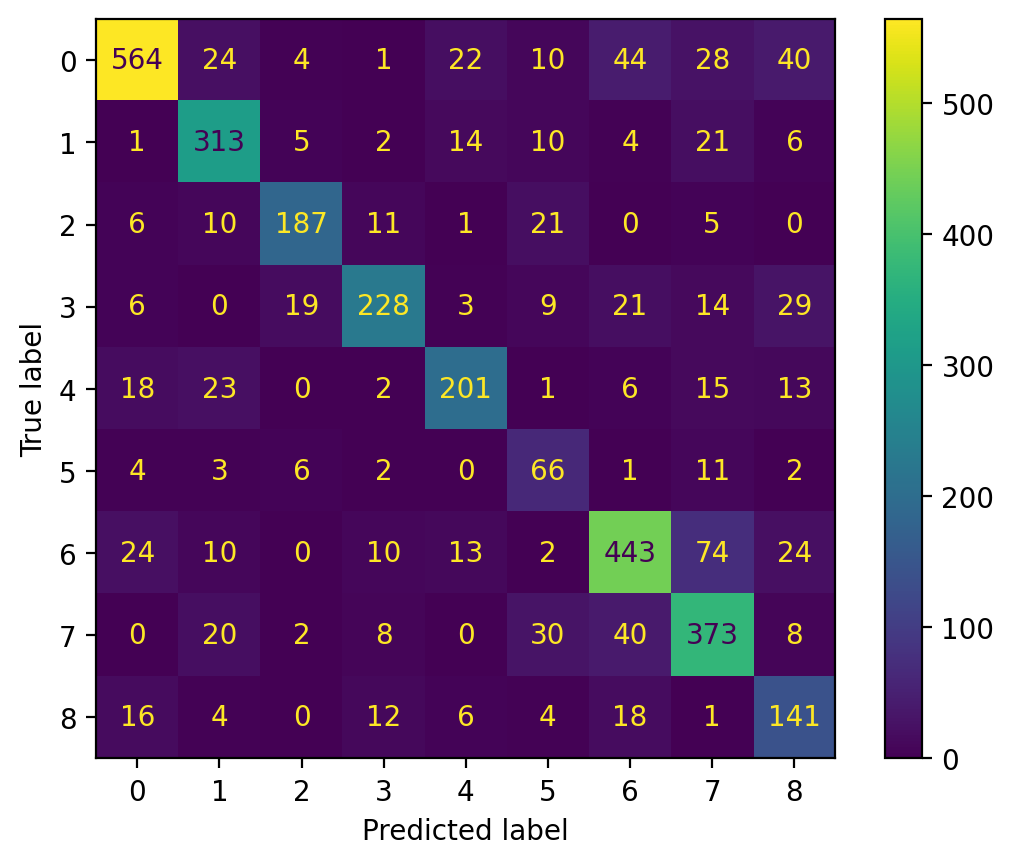

In [ ]:
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import StratifiedKFold
device = torch.device('cpu')
# RNN Parameters
input_size = 6
sequence_length = 512
num_layers = 8
hidden_size = 128
num_classes = len(LABEL_LIST_TRAIN[label])
learning_rate = 1e-3
batch_size = 16
num_epochs = 200
patience = 10
# EMBEDDING Parameters
num_keys = len(df['key'].unique())
key_embed_dim = 4
# GLOBAL FEATURES Parameters
global_feat_dim = 38
global_out_dim = 19
class CNN(nn.Module):
    def __init__(self, input_size, num_classes, num_keys, key_embed_dim, global_feat_dim, global_out_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AdaptiveMaxPool1d(1)  
        )
        
        self.key_embedding = nn.Embedding(num_keys, key_embed_dim)
        
        self.global_fc = nn.Sequential(
            nn.Linear(global_feat_dim, global_out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 + key_embed_dim + global_out_dim, 64),
            #nn.Linear(64 , 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, key, global_feats):
        
        x = x.permute(0, 2, 1)  
        x = self.conv(x)        
        x = x.view(x.size(0), -1)  

        key_vec = self.key_embedding(key)
        global_vec = self.global_fc(global_feats)

        combined = torch.cat([x, key_vec, global_vec], dim=1)
        out = self.classifier(combined)
        return out

actual = []
pred = []
overall_acc = []
plt_val_loss = []
plt_train_loss = []
fold_n = 10

for fold in range(fold_n):
    patience = 10
    best_model = model.state_dict()
    print(f"Fold {fold}:")
    #train_prefixes, test_prefixes = train_test_split(prefixes, stratify=to_stratify, test_size=0.2, random_state=random_state)
    train_prefixes_temp, test_prefixes, train_prefixes_y_temp, test_prefixes_y = train_test_split(prefixes, to_stratify, stratify=to_stratify, test_size=0.2, random_state=random_state * fold)
    train_prefixes, val_prefixes, train_prefixes_y, val_prefixes_y = train_test_split(train_prefixes_temp, train_prefixes_y_temp, stratify=train_prefixes_y_temp, test_size=0.25, random_state=random_state * fold)

    # Step 3: Gather IDs for train and test sets
    train_ids = [id_ for prefix in train_prefixes for id_ in prefix_to_ids[prefix]]
    test_ids = [id_ for prefix in test_prefixes for id_ in prefix_to_ids[prefix]]
    val_ids = [id_ for prefix in val_prefixes for id_ in prefix_to_ids[prefix]]
    
    X_train, y_train = df_windowed[df_windowed['section_id'].isin(train_ids)][['NoteAndRest', 'global_features']], df_windowed[df_windowed['section_id'].isin(train_ids)][label]
    X_test, y_test = df_windowed[df_windowed['section_id'].isin(test_ids)][['NoteAndRest', 'global_features']], df_windowed[df_windowed['section_id'].isin(test_ids)][label]
    X_val, y_val = df_windowed[df_windowed['section_id'].isin(val_ids)][['NoteAndRest', 'global_features']], df_windowed[df_windowed['section_id'].isin(val_ids)][label]
    
    
    # We prepare the train, test and validation loaders
    dataset_train = NoteSequenceDataset(X_train['NoteAndRest'].tolist(), X_train['global_features'].tolist(), y_train.tolist())
    train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
    dataset_test = NoteSequenceDataset(X_test['NoteAndRest'].tolist(), X_test['global_features'].tolist(), y_test.tolist())
    test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
    dataset_val = NoteSequenceDataset(X_val['NoteAndRest'].tolist(), X_val['global_features'].tolist(), y_val.tolist())
    val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

    model = CNN(input_size, num_classes,
                    num_keys, key_embed_dim, global_feat_dim, global_out_dim).to(device)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.tolist()), y=y_train.tolist())
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer= optimizer, step_size=15, gamma=0.1)
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        
        for batch_idx, (sequences, global_feats, labels) in enumerate(train_loader):
            # Reset gradients
            optimizer.zero_grad()   # Float keys are converted into long
            output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])  # Assuming global_feats[:, 0] is the key, global_feats[:, 1:] is the other features
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            """
            # Just for visualization
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)
            if batch_idx % 10 == 0:
                print("Targets:", labels.tolist())
                print("Preds:", preds.tolist())
                print("Probs:", probs.tolist())
                print("Train loss: ", loss) 
            """
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            # Update
            optimizer.step()
        plt_train_loss.append(loss.item())
        # VALIDATION Step
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, global_feats, labels in val_loader:
                output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])
                loss = criterion(output, labels)
                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        print("Val loss", avg_val_loss)
        print("Epoch", epoch)
        plt_val_loss.append(avg_val_loss)
        if avg_val_loss > best_loss:
            patience -= 1
        else:
            best_loss = avg_val_loss
            patience = 10
            best_model = model.state_dict()

        if patience <= 0:
            break
        val_acc = correct / total
        #print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.4f}, Best Val Loss = {best_loss:.4f}, Val Acc = {val_acc:.4f}, Patience = {patience:.4f},")
        scheduler.step()

    print(f"Finished at epoch {epoch}")
    model.load_state_dict(best_model)
    y_pred, y_actual, y_accuracy = (check_accuracy(test_loader, model))
    pred.extend(y_pred)
    actual.extend(y_actual)
    overall_acc.append(y_accuracy)

print_performance(actual, pred, overall_acc)


In [38]:
from torch.optim.lr_scheduler import StepLR
device = torch.device('cpu')
# RNN Parameters
input_size = 6
sequence_length = 512
num_layers = 8
hidden_size = 128
num_classes = len(LABEL_LIST_TRAIN[label])
learning_rate = 1e-3
batch_size = 16
num_epochs = 200
patience = 10
# EMBEDDING Parameters
num_keys = len(df['key'].unique())
key_embed_dim = 4
# GLOBAL FEATURES Parameters
global_feat_dim = 38
global_out_dim = 19
class CNN(nn.Module):
    def __init__(self, input_size, num_classes, num_keys, key_embed_dim, global_feat_dim, global_out_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.AdaptiveMaxPool1d(1)  
        )
        
        self.key_embedding = nn.Embedding(num_keys, key_embed_dim)
        
        self.global_fc = nn.Sequential(
            nn.Linear(global_feat_dim, global_out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 + key_embed_dim + global_out_dim, 64),
            #nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, key, global_feats):
        
        x = x.permute(0, 2, 1)  
        x = self.conv(x)        
        x = x.view(x.size(0), -1)  

        key_vec = self.key_embedding(key)
        global_vec = self.global_fc(global_feats)

        combined = torch.cat([x, key_vec, global_vec], dim=1)
        out = self.classifier(combined)
        return out

actual = []
pred = []
overall_acc = []
plt_val_loss = []
plt_train_loss = []
for fold in range(20):
    # Split train-test-val into 60-20-20
    y = df_windowed[label]
    X_ = df_windowed[['NoteAndRest', 'global_features']]
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X_, y, 
        test_size=0.2,           
        stratify=y,             
        random_state=fold         
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, 
        test_size=0.25,          
        stratify=y_train_temp,             
        random_state=fold        
    )
    X_train
    # We prepare the train, test and validation loaders
    dataset_train = NoteSequenceDataset(X_train['NoteAndRest'].tolist(), X_train['global_features'].tolist(), y_train.tolist())
    train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
    dataset_test = NoteSequenceDataset(X_test['NoteAndRest'].tolist(), X_test['global_features'].tolist(), y_test.tolist())
    test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
    dataset_val = NoteSequenceDataset(X_val['NoteAndRest'].tolist(), X_val['global_features'].tolist(), y_val.tolist())
    val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

    model = CNN(input_size, num_classes,
                    num_keys, key_embed_dim, global_feat_dim, global_out_dim).to(device)


    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train.tolist()), y=y_train.tolist())
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer= optimizer, step_size=15, gamma=0.1)
    best_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        model.train()
        for batch_idx, (sequences, global_feats, labels) in enumerate(train_loader):
            # Reset gradients
            optimizer.zero_grad()   # Float keys are converted into long
            output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])  # Assuming global_feats[:, 0] is the key, global_feats[:, 1:] is the other features
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            """
            # Just for visualization
            probs = torch.softmax(output, dim=1)
            preds = torch.argmax(probs, dim=1)
            if batch_idx % 10 == 0:
                print("Targets:", labels.tolist())
                print("Preds:", preds.tolist())
                print("Probs:", probs.tolist())
                print("Train loss: ", loss) 
            """
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            # Update
            optimizer.step()
        plt_train_loss.append(loss.item())
        # VALIDATION Step
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, global_feats, labels in val_loader:
                output = model(sequences, global_feats[:, -1].long(), global_feats[:, :-1])
                loss = criterion(output, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        plt_val_loss.append(avg_val_loss)
        if avg_val_loss > best_loss:
            patience -= 1
        else:
            best_loss = avg_val_loss
            patience = 10

        if patience <= 0:
            break
        val_acc = correct / total
        #print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.4f}, Best Val Loss = {best_loss:.4f}, Val Acc = {val_acc:.4f}, Patience = {patience:.4f},")
        scheduler.step()

    print(f"Finished at epoch {epoch}")
    y_pred, y_actual, y_accuracy = (check_accuracy(test_loader, model))
    pred.extend(y_pred)
    actual.extend(y_actual)
    overall_acc.append(y_accuracy)

print_performance(actual, pred, overall_acc)


Finished at epoch 44
Predictions: [2, 7, 7, 2, 8, 4, 0, 0, 2, 2, 0, 7, 7, 8, 3, 2]
Actual: [2, 7, 7, 2, 8, 4, 0, 7, 2, 2, 0, 7, 7, 3, 3, 2]
Predictions: [0, 8, 1, 6, 8, 2, 6, 3, 8, 0, 1, 7, 3, 6, 1, 0]
Actual: [0, 8, 1, 6, 8, 2, 6, 3, 8, 0, 1, 7, 3, 6, 4, 0]
Predictions: [0, 4, 0, 0, 1, 6, 3, 5, 8, 0, 4, 6, 1, 4, 7, 6]
Actual: [0, 4, 0, 0, 1, 7, 3, 5, 8, 0, 4, 6, 1, 4, 7, 6]
Predictions: [4, 3, 7, 2, 7, 0, 0, 4, 0, 0, 0, 0, 4, 8, 5, 1]
Actual: [4, 3, 7, 2, 7, 0, 0, 4, 0, 0, 0, 7, 4, 8, 5, 1]
Predictions: [1, 8, 6, 6, 0, 4, 3, 6, 6, 5, 0, 5, 0, 3, 0, 8]
Actual: [1, 8, 6, 6, 6, 4, 3, 7, 6, 5, 0, 5, 0, 3, 0, 8]
Predictions: [8, 6, 7, 4, 0, 1, 5, 1, 1, 6, 6, 6, 2, 3, 7, 7]
Actual: [8, 6, 7, 4, 0, 1, 5, 1, 1, 6, 6, 6, 2, 3, 7, 1]
Predictions: [0, 7, 0, 0, 1, 6, 7, 1, 0, 6, 4, 6, 8, 4, 1, 6]
Actual: [7, 7, 0, 0, 1, 6, 7, 1, 0, 6, 4, 6, 8, 4, 1, 6]
Predictions: [6, 7, 0, 0, 4, 6, 3]
Actual: [6, 7, 0, 0, 4, 6, 3]
Got 110 / 119 correct with accuracy 92.44
Finished at epoch 20
Predictions: [6, 1

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

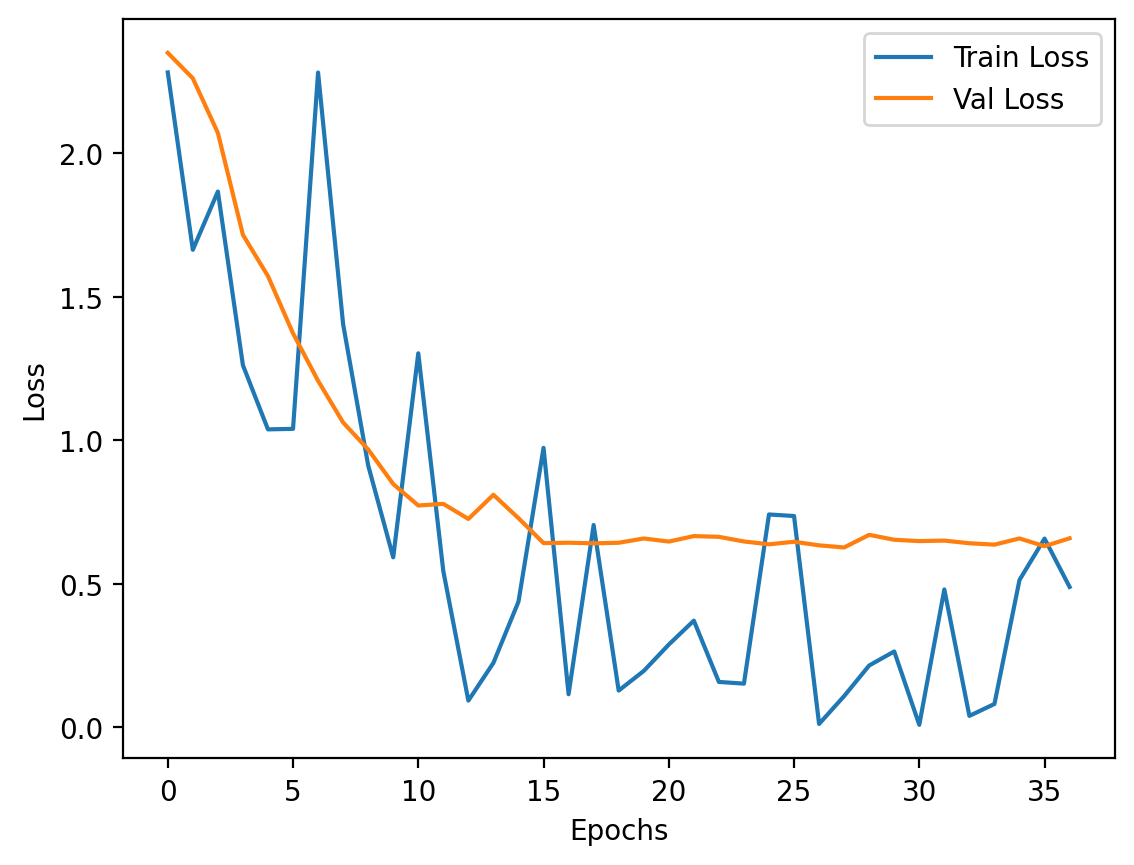

In [ ]:
plt.plot([x for x in range(37)], plt_train_loss[:37], label = "Train Loss")
plt.plot([x for x in range(37)], plt_val_loss[:37], label = "Val Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [52]:
check_accuracy(test_loader, model)

Checking accuracy on training data
Predictions: [0, 3, 6, 1, 0, 0, 0, 1, 2, 0, 0, 2, 1, 6, 6, 0]
Actual: [0, 3, 6, 1, 0, 0, 0, 2, 2, 0, 1, 2, 1, 0, 6, 0]
Predictions: [0, 1, 0, 6, 2, 5, 6, 5, 7, 4, 8, 0, 1, 7, 1, 1]
Actual: [0, 1, 0, 6, 2, 5, 6, 5, 5, 4, 8, 0, 1, 7, 1, 1]
Predictions: [0, 4, 0, 4, 0, 1, 7, 4, 5, 8, 3, 6, 8, 4, 8, 0]
Actual: [1, 4, 0, 4, 0, 7, 7, 4, 5, 8, 3, 6, 8, 4, 8, 7]
Predictions: [0, 5, 7, 7, 5, 4, 3, 5, 6, 1, 0, 7, 6, 0, 2, 4]
Actual: [0, 2, 7, 7, 5, 4, 3, 3, 6, 1, 0, 7, 6, 0, 2, 4]
Predictions: [0, 2, 7, 7, 0, 8, 0, 6, 8, 6, 1, 4, 5, 3, 6, 7]
Actual: [0, 2, 4, 5, 0, 8, 0, 6, 8, 6, 1, 4, 3, 3, 6, 7]
Predictions: [8, 0, 1, 2, 6, 6, 1, 4, 0, 6, 8, 5, 6, 0, 6, 6]
Actual: [8, 6, 1, 2, 6, 6, 1, 4, 0, 6, 3, 5, 6, 0, 6, 6]
Predictions: [0, 4, 0, 0, 3, 8, 7, 7, 3, 3, 3, 0, 3, 4, 0, 1]
Actual: [0, 4, 8, 0, 6, 8, 7, 7, 3, 3, 3, 0, 3, 4, 0, 1]
Predictions: [1, 7, 6, 7, 7, 0, 8, 0, 7, 0, 7, 6, 1, 7, 4, 6]
Actual: [1, 1, 6, 7, 7, 6, 8, 0, 7, 1, 7, 6, 8, 7, 4, 6]
Predictions: 